In [6]:
%matplotlib inline

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import random
import math
import time

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [9]:
transform_mnist = transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))])

transform_cifar = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [10]:
train_c10_full= torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_cifar)
test_c10 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_cifar)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [11]:
train_mnist_full = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform_mnist)
test_mnist = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform_mnist)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [72]:
train_fmnist_full = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform_mnist)
test_fmnist = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform_mnist)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw





Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


In [73]:
#this code needs to be in a function , that generates a training set and validation set from an
#input dataset and input minibatch size.  In this case, we call
#train_loader, validation_loader = function(train_c10_full, 32)

# p between 0 and 1, percent of data in tr_loader, q into validationloader
def train_val_split(train_data, minibatch_size, p, q):
    idx_range = list(range(0,len(train_data)))
    random.shuffle(idx_range)
    
    p_idx = int(p * len(idx_range))
    pq_idx = int((p+q) * len(idx_range))
    #middle = len(idx_range)//2
    tr_idx = idx_range[:p_idx]
    val_idx = idx_range[p_idx:pq_idx]
    
    train_subset = torch.utils.data.Subset(train_data, tr_idx)
    val_subset = torch.utils.data.Subset(train_data, val_idx)
    
    tr_loader = torch.utils.data.DataLoader(train_subset, batch_size=minibatch_size,
                                          shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=minibatch_size,
                                          shuffle=True, num_workers=2)
    return tr_loader, val_loader


In [79]:
#CIFAR10 dataloaders
train_c10_loader, val_c10_loader = train_val_split(train_c10_full, 32, 0.8, 0.2)


train_c10_mini, val_c10_mini = train_val_split(train_c10_full, 32, 0.05, 0.05)


test_c10_loader = torch.utils.data.DataLoader(test_c10, batch_size=32,
                                         shuffle=False, num_workers=2)


#MNIST dataloaders
train_mnist_loader,  val_mnist_loader = train_val_split(train_mnist_full, 32, 0.8, 0.2)

test_mnist_loader = torch.utils.data.DataLoader(test_mnist, batch_size=32,
                                         shuffle=False, num_workers=2)

#Fashion-MNIST dataloaders
train_fmnist_loader,  val_fmnist_loader = train_val_split(train_fmnist_full, 32, 0.8, 0.2)

test_fmnist_loader = torch.utils.data.DataLoader(test_fmnist, batch_size=32,
                                         shuffle=False, num_workers=2)

c10_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
mnist_classes = ('0','1','2','3','4','5','6','7','8','9')

fmnist_classes = ('t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')

In [80]:
print(train_fmnist_full)


Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


In [81]:
#un-normalize and display an imaage from a dataset
def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()


In [82]:
#show_sample will display the first minibatch of dataloader dl
#with the first 4 images labeled according to dl_classes
def show_samples(dl, dl_classes):

    # get some random training images
    dataiter = iter(dl)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % dl_classes[labels[j]] for j in range(4)))


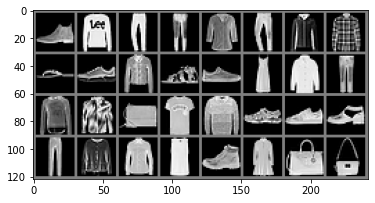

ankle boot pullover trouser trouser


In [83]:
show_samples(test_fmnist_loader, fmnist_classes)

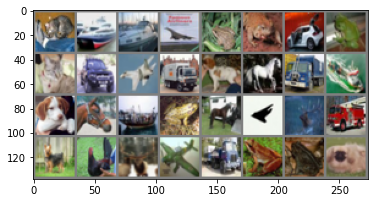

  cat  ship  ship plane


In [84]:
show_samples(test_c10_loader, c10_classes)

In [85]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# This section is where we explore different NN architectures

In [86]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [88]:
print(MNISTNet())

MNISTNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [65]:
class c10Net(nn.Module):
    def __init__(self):
        super(c10Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [66]:
print('hey bud')

hey bud


In [89]:
#compute the accuracy of net net identifying the classes of data in the dataloader dl
def compute_accuracy(net, dl):
    correct = 0
    total = 0
    with torch.no_grad():
        for (images, labels) in dl:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [90]:
#this one's pretty self explanatory- it runs neural net net for epochs epochs, training on the
#data in trainloader and computing training + validation accuracy after each epoch
def run_net(net, epochs, trainloader, validationloader, print_mode = False):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=0.9)
    train_acc_list = []
    val_acc_list = []
    train_start = time.time()

    net = net.to(device)

    for epoch in range(epochs):  # loop over the dataset multiple times
        #running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        train_acc = compute_accuracy(net, trainloader)
        val_acc = compute_accuracy(net, validationloader)
        
        current = time.time()
        
        if(print_mode):
            print('Epoch: %d Train Acc: %d%% Val Acc: %d%% Time: %ds' % \
                 (epoch+1,train_acc,val_acc, current-train_start))
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
    train_end = time.time()
    print('Finished Training')
    
    return(train_acc_list, val_acc_list, train_end-train_start)

In [91]:
net = MNISTNet()
train_acc_list, validation_acc_list, _ = run_net(net, 10, train_fmnist_loader, val_fmnist_loader, True)
#t1, v1 = train_acc_list, validation_acc_list

Epoch: 1 Train Acc: 77% Val Acc: 76% Time: 23s
Epoch: 2 Train Acc: 82% Val Acc: 81% Time: 46s
Epoch: 3 Train Acc: 84% Val Acc: 83% Time: 70s
Epoch: 4 Train Acc: 87% Val Acc: 85% Time: 93s
Epoch: 5 Train Acc: 87% Val Acc: 86% Time: 117s
Epoch: 6 Train Acc: 87% Val Acc: 86% Time: 140s
Epoch: 7 Train Acc: 88% Val Acc: 87% Time: 163s
Epoch: 8 Train Acc: 89% Val Acc: 87% Time: 187s
Epoch: 9 Train Acc: 90% Val Acc: 88% Time: 210s
Epoch: 10 Train Acc: 89% Val Acc: 88% Time: 233s
Finished Training


In [92]:
print(train_acc_list)


[77.025, 82.1625, 84.50833333333334, 87.08333333333333, 87.06041666666667, 87.92083333333333, 88.825, 89.11458333333333, 90.20833333333333, 89.97916666666667]


Let's quickly save our trained model:



In [93]:
# PATH = './cifar_net.pth'
# PATH_MNIST = './mnist_net.pth'
# torch.save(net.state_dict(), PATH_MNIST)

In [94]:
# net = Net()
# net.load_state_dict(torch.load(PATH))

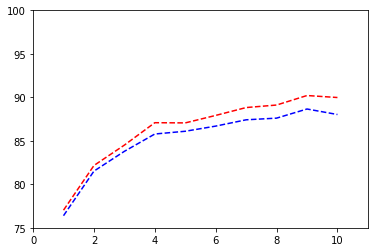

In [96]:
epoch_list = list(range(1,len(train_acc_list)+1))
plt.plot(epoch_list, train_acc_list, 'r--', epoch_list, validation_acc_list, 'b--')
plt.axis([0,len(t1), 75, 100])
#TODO: plt.legend() 
plt.show()

Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why dont I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

Training on multiple GPUs
-------------------------
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

Where do I go next?
-------------------

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_


